# Cheat sheet

Here we provide quick reference calculation for some of the most common X-ray spectrum calculations, considering XPS/IE, XAS, and (non-resonant) XES of water, as well as a typical workflow.


## Typical workflow

- Perform [structure optimization](../mol_struct/opt_gs)
- Calculate the spectra/ionization energies
    - Choose suitable [level of theory](xray_rec)
    - Depending on spectroscopy:
        - [Ionization energy](sec:xray_calc_xps): using [$\Delta$-methods](sec:xray_calc_dscf), or target transitions to extremely [diffuse MOs](sec:xray_ie_diffuse)
        - [XAS](sec:xray_calc_xas): [CVS-ADC](sec:xray_calc_cvsadc), [CPP-DFT](sec:xray_calc_cppdft), or [CVS-TDSCF](sec:xray_calc_cvsdft)
        - [XES](sec:xray_calc_xes): [ADC](sec:xray_calc_xesadc), [TDSCF](sec:xray_calc_xesdft), and using [ground state MOs](sec:xray_calc_xesmos)
        - [RIXS](sec:xray_calc_rixs): two-step model with [ADC](sec:xray_calc_2stepadc)
- Analysis and assignment of the spectra
    - Looking at [amplitudes](sec:xray_anal_amp)
    - Visualization
        - [Molecular orbitals](../visualize/exc_vis.ipynb)
        - [Natural transition orbitals](sec:vis_ntos)
        - [Attachment/detachment densities](sec:vis_attach_det)
        

## IEs and XPS


### Koopmans' theorem

While it is not recommended for any production calculations, estimates of ionization energies can be obtained from [Koopmans' theorem](sec:xray_calc_iekoop):

In [1]:
import numpy as np
import veloxchem as vlx

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI

comm = MPI.COMM_WORLD
# au to eV conversion factor
au2ev = 27.211386

water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_str(water_xyz)
bas_vlx = vlx.MolecularBasis.read(mol_vlx, "6-31G")

# Perform SCF calculation
scf_gs = vlx.ScfRestrictedDriver(comm, ostream=silent_ostream)
scf_gs.compute(mol_vlx, bas_vlx)

# Extract orbital energies
orbital_energies = scf_gs.scf_tensors["E"]
print("1s E from Koopmans' theorem:", np.around(au2ev * orbital_energies[0], 2), "eV")

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.10/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: 6-31G                                                                            
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                               

### $\Delta$-methods

Substantially improved ionization energies are obtained using [$\Delta$-methods](sec:xray_calc_dscf), where the energy difference of the ground state and core-hole state is used to estimate the IE:

In [2]:
import copy

import numpy as np
from pyscf import gto, mp, scf

water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "6-31G"
mol.build()

# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()

# Copy molecular orbitals and occupations
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0

# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Run MP2 on neutral and core-hole state
mp_res = mp.MP2(scf_gs).run()
mp_ion = mp.MP2(scf_ion).run()

# IE from energy difference
print(
    "HF ionization energy:",
    np.around(au2ev * (scf_ion.energy_tot() - scf_gs.energy_tot()), 2),
    "eV",
)
print(
    "MP2 ionzation energy:", np.around(au2ev * (mp_ion.e_tot - mp_res.e_tot), 2), "eV"
)

converged SCF energy = -75.9838703827192  <S^2> = 6.3344885e-12  2S+1 = 1


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>


converged SCF energy = -56.0754789470865  <S^2> = 0.76257805  2S+1 = 2.0125387
E(UMP2) = -76.1130483955489  E_corr = -0.129178012829706
E(UMP2) = -56.1523709631035  E_corr = -0.0768920160169649
HF ionization energy: 541.73 eV
MP2 ionzation energy: 543.16 eV


## XAS

### CVS-ADC

Absorption spectra can be calculated using [CVS-ADC](sec:xray_calc_cvsadc):

In [3]:
import gator
import matplotlib.pyplot as plt

water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Construct structure and basis objects
struct = gator.get_molecule(water_xyz)
basis = gator.get_molecular_basis(struct, "6-31G")

# Perform SCF calculation
scf_gs = gator.run_scf(struct, basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_res = gator.run_adc(
    struct, basis, scf_gs, method="cvs-adc2x", singlets=4, core_orbitals=1
)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.10/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: 6-31G                                                                            
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                                                                                                          
        

AttributeError: 'ScfRestrictedDriver' object has no attribute 'num_iter'

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175       0.8       0.2  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
+--------------------------------------------------------------+



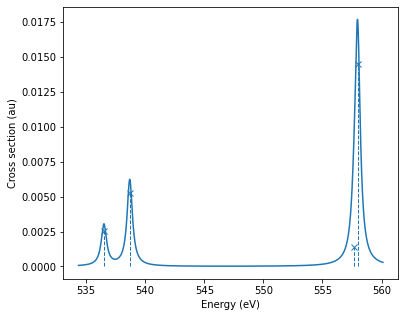

In [4]:
# Print information on eigenstates
print(adc_res.describe())

plt.figure(figsize=(6, 5))
# Convolute using functionalities available in gator and adcc
adc_res.plot_spectrum()
plt.show()

### CPP-DFT

- To be added

## XES

### ADC

The non-resonant X-ray emission spectrum can be calculated with a two-step approach using [ADC](sec:xray_calc_xesadc):

In [5]:
import copy

import adcc
import matplotlib.pyplot as plt
import numpy as np
from pyscf import gto, mp, scf

water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create pyscf mol object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "6-31G"
mol.build()

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbitals
mo0 = copy.deepcopy(scf_res.mo_coeff)
occ0 = copy.deepcopy(scf_res.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0

# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculation
adc_xes = adcc.adc2(scf_ion, n_states=4)

converged SCF energy = -75.9838703827193  <S^2> = 6.3433703e-12  2S+1 = 1
converged SCF energy = -56.0754789470865  <S^2> = 0.76257805  2S+1 = 2.0125387
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   2.0s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  372ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  757ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             3s 185ms


+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      -19.4443     -529.1063   0.0568    0.9548    0.0452  |
|  1     -19.36693      -527.001   0.0458    0.9503   0.04966  |
|  2     -19.16832     -521.5965   0.0419    0.9376   0.06245  |
|  3     -18.57955     -505.5753   0.0031    0.9335   0.06655  |
+--------------------------------------------------------------+



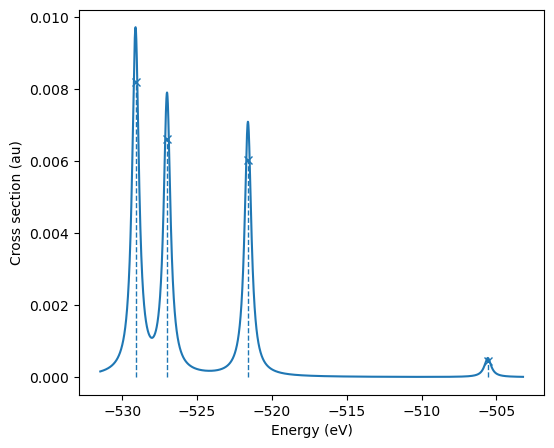

In [6]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6, 5))
# Convolute using functionalities available in gator and adcc
adc_xes.plot_spectrum()
plt.show()


### Ground state MOs

To be added, using the approach [here](sec:xray_calc_xesmos).